# Demo for processing NIRSpec data from DD-2756 (PI: Pat Kelly)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import msaexp
from msaexp import pipeline

print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.3


In [2]:
os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [3]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2767, download=True, gratings=['prism'], detectors=['nrs2'])

2022-11-07 14:43:32,015 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [4]:
groups = pipeline.exposure_groups()
groups

   N  value     
====  ==========
   3  jw02767005001-02-clear-prism-nrs2


{'jw02767005001-02-clear-prism-nrs2': ['jw02767005001_03105_00002_nrs2_rate.fits',
  'jw02767005001_03105_00003_nrs2_rate.fits',
  'jw02767005001_03105_00004_nrs2_rate.fits']}

In [5]:
pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-clear-prism-nrs2')

# (2022-11-07 13:43:32.057)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits


## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [6]:
# Run the pipeline to define slits, etc., but don't do extractions yet.  
pipe.full_pipeline(run_extractions=False)

msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.000.fits background_73
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.001.fits background_76
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.002.fits background_77
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.003.fits background_78
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.004.fits background_79
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.005.fits background_80
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.006.fits background_82
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.007.fits background_83
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.008.fits background_84
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.009.fits background_85
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.010.fits background_88
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.011.fits background_89
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.012.fits background_90

msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.005.fits 2767_6065
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.006.fits 2767_5363
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.007.fits background_83
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.008.fits 2767_5701
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.009.fits background_85
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.010.fits background_88
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.011.fits 2767_5808
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.012.fits 2767_6141
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.013.fits 2767_5884
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.014.fits background_97
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.015.fits background_101
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.016.fits 2767_5082
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.017.fits 2767_5757
msaexp.read_data: jw0276700500

msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.015.fits background_101
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.016.fits background_102
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.017.fits background_103
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.018.fits background_104
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.019.fits background_108
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.020.fits background_111
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.021.fits background_113
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.022.fits background_114
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.023.fits background_115
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.024.fits background_117
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.025.fits background_119
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.026.fits background_120
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.027.fits b

In [7]:
# initialize background-subtracted slit objects for drizzling below
pipe.set_background_slits()

msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.000.fits background_73
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.001.fits background_76
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.002.fits background_77
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.003.fits background_78
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.004.fits background_79
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.005.fits background_80
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.006.fits background_82
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.007.fits background_83
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.008.fits background_84
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.009.fits background_85
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.010.fits background_88
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.011.fits background_89
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.012.fits background_90

msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.005.fits 2767_6065
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.006.fits 2767_5363
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.007.fits background_83
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.008.fits 2767_5701
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.009.fits background_85
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.010.fits background_88
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.011.fits 2767_5808
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.012.fits 2767_6141
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.013.fits 2767_5884
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.014.fits background_97
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.015.fits background_101
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.016.fits 2767_5082
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.017.fits 2767_5757
msaexp.read_data: jw0276700500

msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.015.fits background_101
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.016.fits background_102
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.017.fits background_103
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.018.fits background_104
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.019.fits background_108
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.020.fits background_111
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.021.fits background_113
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.022.fits background_114
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.023.fits background_115
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.024.fits background_117
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.025.fits background_119
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.026.fits background_120
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.027.fits b

True

In [8]:
! ls {pipe.mode}*

jw02767005001-02-clear-prism-nrs2.log.txt
jw02767005001-02-clear-prism-nrs2.reg
jw02767005001-02-clear-prism-nrs2.slits.reg
jw02767005001-02-clear-prism-nrs2.slits.yaml


In [9]:
# Parse slit polygons
# try to use the slitlet WCS to generate a polygon in sky coordinates of the slit locations
if not os.path.exists('jw02767005001-02-clear-prism-nrs2.slits.reg'):
    pipe.get_slit_polygons()

## Pipeline products

In [10]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  ['phot', 'bkg']
Last step:  phot


## Slitlet metadata

In [11]:
pipe.slitlets.keys()

dict_keys(['2767_6403', 'background_76', '2767_5632', '2767_6372', '2767_6221', '2767_6065', '2767_5363', 'background_83', '2767_5701', 'background_85', 'background_88', '2767_5808', '2767_6141', '2767_5884', 'background_97', 'background_101', '2767_5082', '2767_5757', '2767_5320', '2767_6435', '2767_5020', '2767_6294', '2767_6001', '2767_5005', '2767_5951', '2767_6225', '2767_5998', '2767_6048', '2767_5899', '2767_5414', '2767_5288', '2767_5609', '2767_4882', '2767_5705', '2767_4970', 'background_136', '2767_5361', '2767_4642', '2767_4971', 'background_142', '2767_5167', '2767_4338', '2767_11022', '2767_4932', '2767_4613', 'background_157', '2767_11019', '2767_4662', '2767_4286', '2767_4323', '2767_11023', '2767_3455', '2767_3450', '2767_3808', 'background_71', '2767_4497', '2767_4093', 'background_75', '2767_4156', '2767_4209', '2767_3698', '2767_3726', '2767_3488', '2767_3002', '2767_3112', '2767_3496', '2767_3425', '2767_2798', 'background_100', '2767_10001', '2767_3108', '2767_269

# Extract spectra

yoffset : offset in pixels relative to where the slit WCS thinks the target coordinates should be
prof_sigma : gaussian profile sigma width
skip : list of indices to exclude from the combination to avoid bad pixels, misalignment, etc.

2022-11-07 14:45:49,631 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



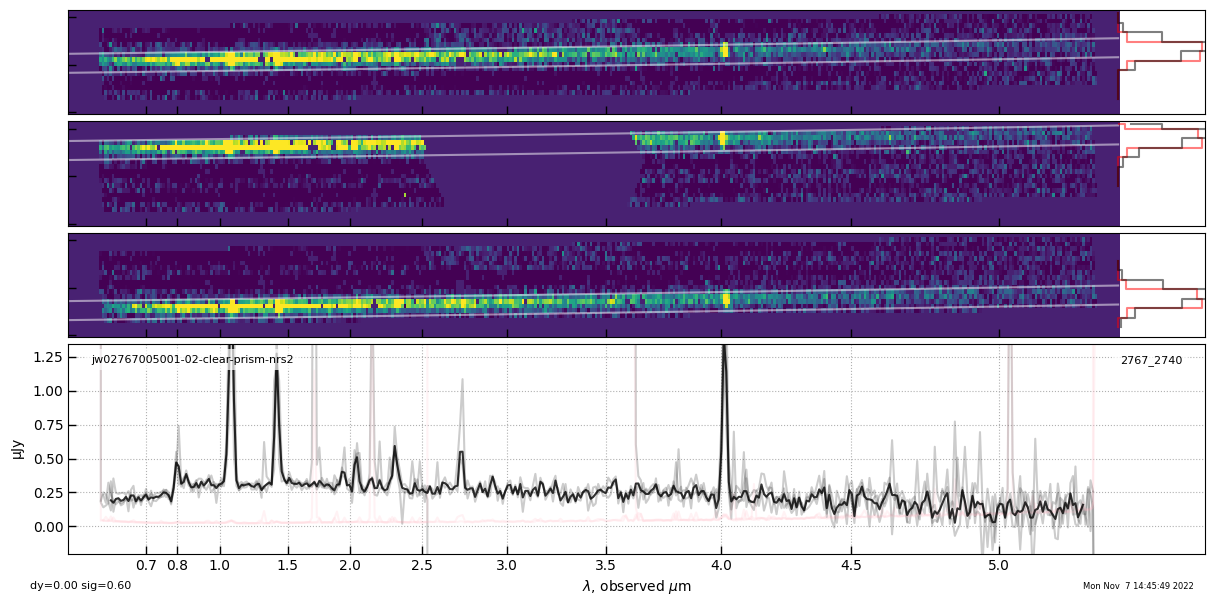

In [12]:
key = '2767_11027' # z=9.5 galaxy from Williams et al.
key = '2767_2740' # z=1.14 with lines

_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, fit_profile_params=None)

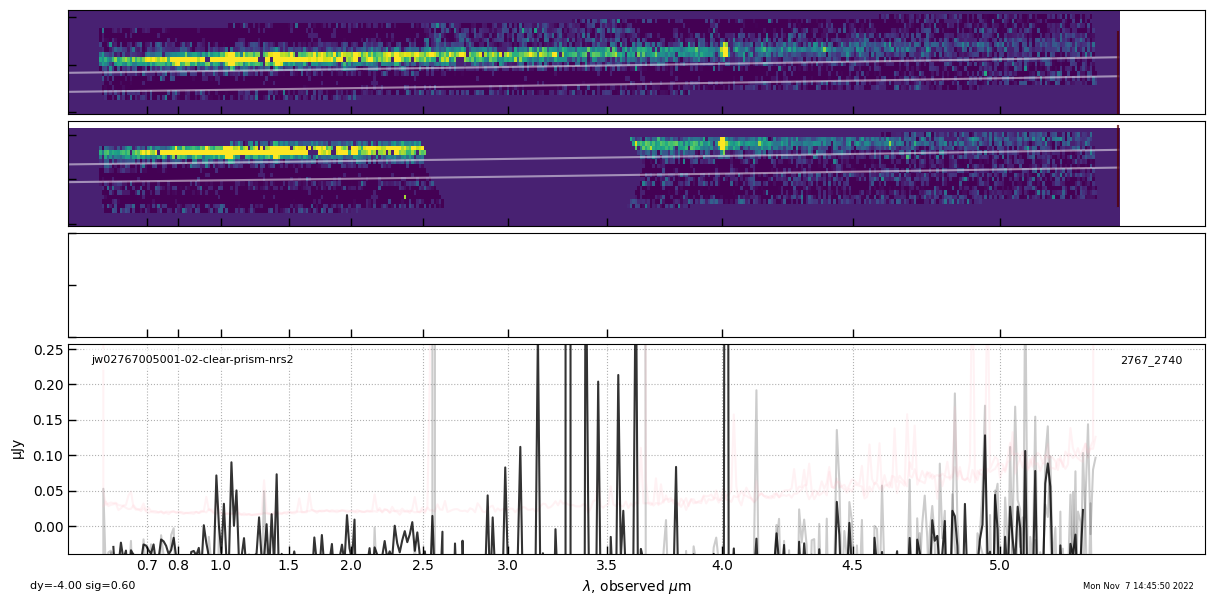

In [13]:
# Shift the extraction along the slit (bad here)
_ = pipe.extract_spectrum(key, skip=[], yoffset=-4, prof_sigma=0.6, fit_profile_params=None)

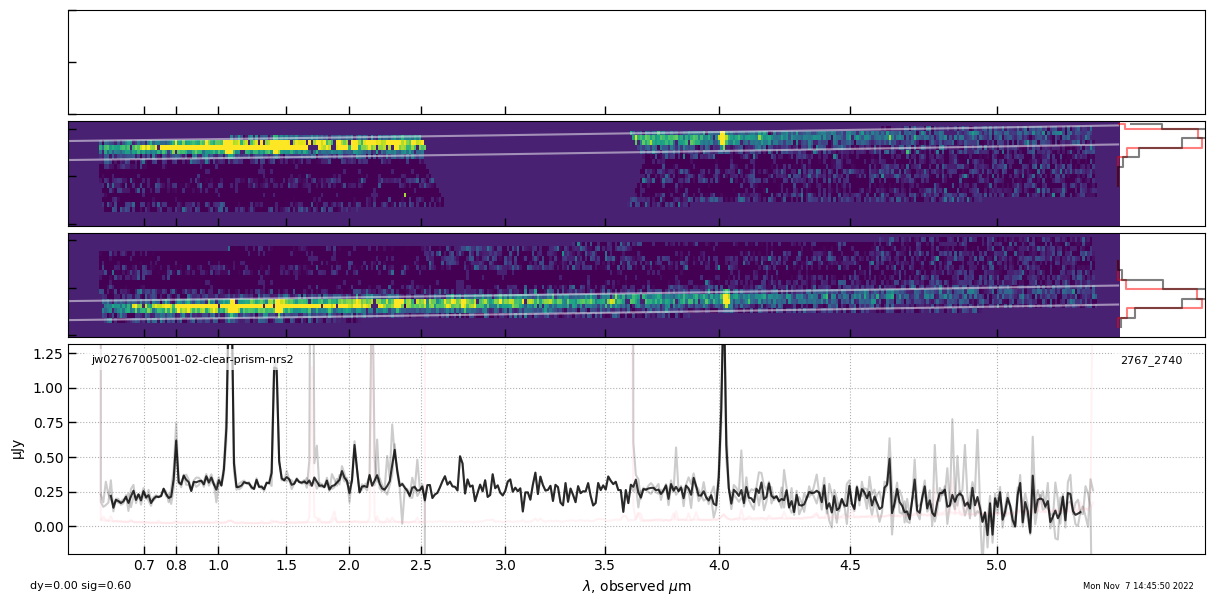

In [14]:
# Exclude first exposure
_ = pipe.extract_spectrum(key, skip=[0], yoffset=0, prof_sigma=0.6, fit_profile_params=None)

2022-11-07 14:45:50,954 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/msaexp/pipeline.py:615: OptimizeWarning: Unknown solver options: direc
  _res = minimize(_objfun_fit_profile, x0,



msaexp.fit_profile:      2767_2740             (dchi2 =   2684.4) yoffset = 0.32  prof_sigma = 0.70 dchi2 =   1874.3


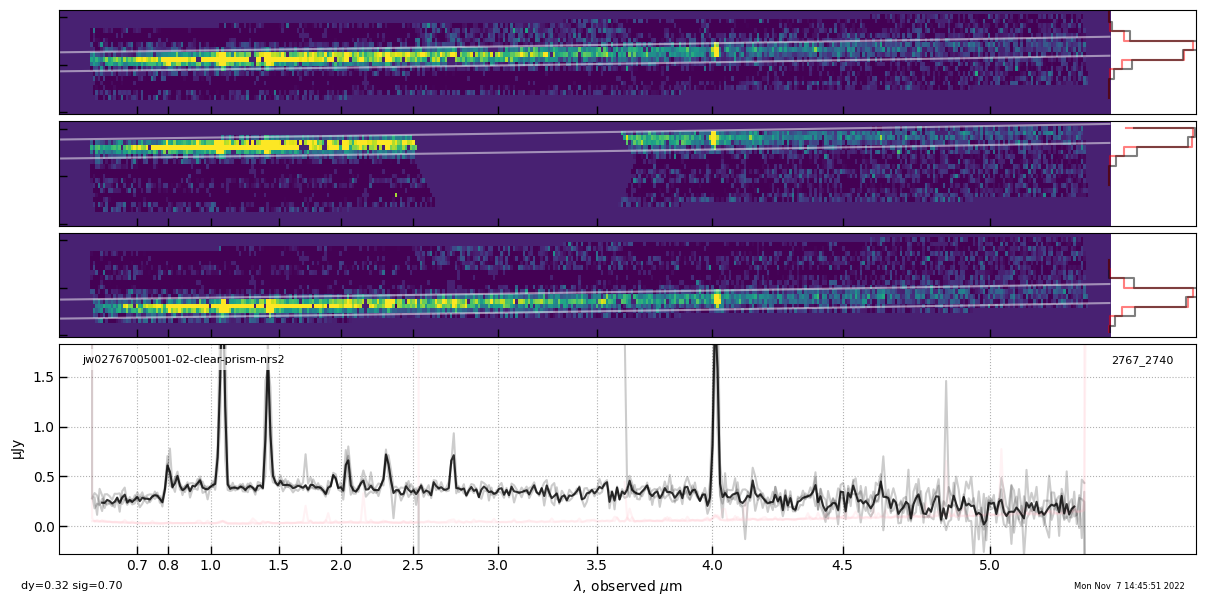

In [15]:
# Fit optimal profile
_data = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, fit_profile_params={'min_delta':20})
slitlet, sep1d, opt1d, fig = _data

## Drizzled 2D spectrum

In [16]:
# Get background-subtracted slitlets
slits = pipe.get_background_slits(key, step='bkg', check_background=True)
len(slits)

3

In [17]:
import msaexp.utils

drizzle_params = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.5,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

# Drizzle each exposure
kwargs = {'keep_wave':1}
wave, header, results = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)


2022-11-07 14:45:51,696 - stpipe - INFO - Driz parameter kernal: square
2022-11-07 14:45:51,696 - stpipe - INFO - Driz parameter pixfrac: 0.5
2022-11-07 14:45:51,697 - stpipe - INFO - Driz parameter fillval: 0
2022-11-07 14:45:51,697 - stpipe - INFO - Driz parameter weight_type: ivm


build_regular_wavelength_wcs: Set linear wave grid (dlam=103.2 Ang)


2022-11-07 14:45:51,846 - stpipe - INFO - Blending metadata for None
2022-11-07 14:45:52,392 - stpipe - INFO - Resampling science data
2022-11-07 14:45:52,419 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:52,420 - stpipe - INFO - Resampling var_rnoise
2022-11-07 14:45:52,448 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:52,451 - stpipe - INFO - Resampling var_poisson
2022-11-07 14:45:52,478 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:52,480 - stpipe - INFO - Resampling var_flat
2022-11-07 14:45:52,507 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:52,603 - stpipe - INFO - Blending metadata for None
2022-11-07 14:45:53,147 - stpipe - INFO - Resampling science data
2022-11-07 14:45:53,174 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:53,175 - stpipe - INFO - Resampling var_rnoise
2022-11-07 14:45:53,203 - stpipe - INFO - Drizzling (22, 419) --> (28, 421)
2022-11-07 14:45:53

In [18]:
# Combine drizzled products with outlier rejection
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d, wht2d, p2d, spec = msaexp.utils.combine_2d_with_rejection(results, sigma=5, **prf_kwargs)

2022-11-07 14:45:54,027 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Set prf_center: 1.0 (28, 421) 5
fit_prf: center = 1.36. sigma = 0.91


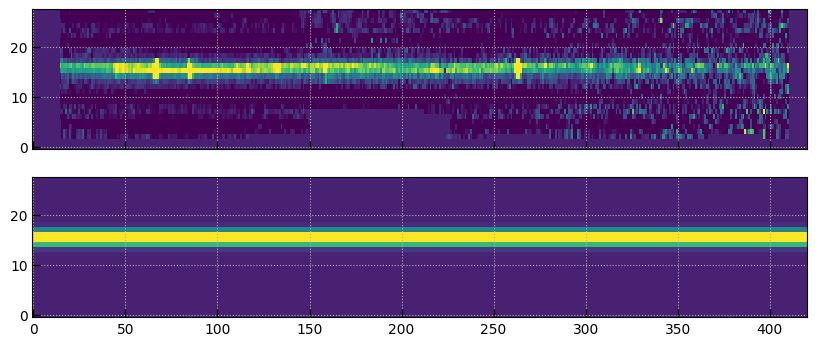

In [19]:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True)
axes[0].imshow(sci2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
axes[1].imshow(p2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
for ax in axes:
    ax.grid()

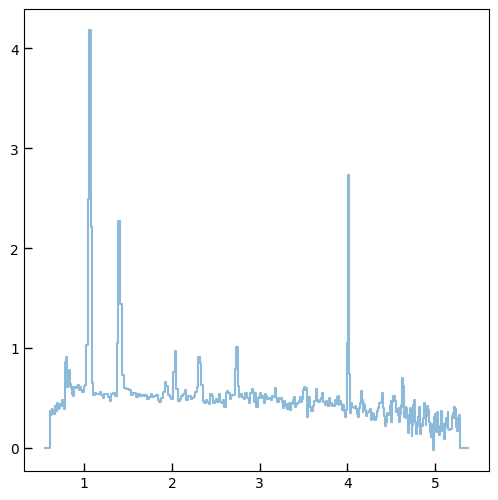

In [20]:
plt.step(spec['wave'], spec['flux'], alpha=0.5)

In [21]:
# Drizzle to a grid that oversamples the wavelengths by x2
kwargs = {'keep_wave':2}
wave2, header2, results2 = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)

2022-11-07 14:45:54,466 - stpipe - INFO - Driz parameter kernal: square
2022-11-07 14:45:54,467 - stpipe - INFO - Driz parameter pixfrac: 0.5
2022-11-07 14:45:54,467 - stpipe - INFO - Driz parameter fillval: 0
2022-11-07 14:45:54,467 - stpipe - INFO - Driz parameter weight_type: ivm


build_regular_wavelength_wcs: Oversample original wavelength grid x 2


2022-11-07 14:45:54,626 - stpipe - INFO - Blending metadata for None
2022-11-07 14:45:55,170 - stpipe - INFO - Resampling science data
2022-11-07 14:45:55,196 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55,197 - stpipe - INFO - Resampling var_rnoise
2022-11-07 14:45:55,227 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55,230 - stpipe - INFO - Resampling var_poisson
2022-11-07 14:45:55,257 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55,260 - stpipe - INFO - Resampling var_flat
2022-11-07 14:45:55,287 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55,389 - stpipe - INFO - Blending metadata for None
2022-11-07 14:45:55,936 - stpipe - INFO - Resampling science data
2022-11-07 14:45:55,962 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55,964 - stpipe - INFO - Resampling var_rnoise
2022-11-07 14:45:55,991 - stpipe - INFO - Drizzling (22, 419) --> (28, 841)
2022-11-07 14:45:55

In [22]:
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d2, wht2d2, p2d2, spec2 = msaexp.utils.combine_2d_with_rejection(results2, sigma=5, **prf_kwargs)

2022-11-07 14:45:56,821 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Set prf_center: 1.0 (28, 841) 5
fit_prf: center = 1.36. sigma = 0.90


(3.9, 4.1)

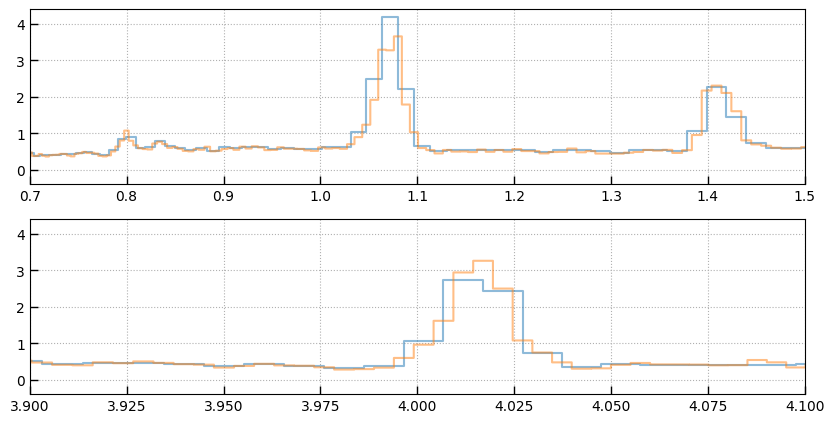

In [23]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
for ax in axes:
    ax.step(spec['wave'], spec['flux'], alpha=0.5, where='mid')
    ax.step(spec2['wave'], spec2['flux'], alpha=0.5, where='mid')
    ax.grid()

axes[0].set_xlim(0.7, 1.5)
axes[1].set_xlim(3.9, 4.1)

# 2D drizzle helper

`msaexp.utils.drizzle_2d_pipeline` does the 2D drizzle steps above and wraps the output into a FITS HDU

In [24]:
from importlib import reload
reload(msaexp.utils)

import grizli.utils
grizli.utils.set_warnings()

DRIZZLE_PARAMS = dict(output=None,
                      single=False,
                      blendheaders=True,
                      pixfrac=0.6,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

slits = pipe.get_background_slits(key, step='bkg', check_background=True)

hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                        fit_prf=True,
                                        prf_center=None, prf_sigma=0.6, center_limit=4, 
                                        standard_waves=1)

build_regular_wavelength_wcs: Set user-defined wavelength grid (size=410)


2022-11-07 14:45:57,293 - stpipe - INFO - Driz parameter kernal: square
2022-11-07 14:45:57,293 - stpipe - INFO - Driz parameter pixfrac: 0.6
2022-11-07 14:45:57,294 - stpipe - INFO - Driz parameter fillval: 0
2022-11-07 14:45:57,294 - stpipe - INFO - Driz parameter weight_type: ivm
2022-11-07 14:45:57,441 - stpipe - INFO - Blending metadata for None
2022-11-07 14:46:00,822 - stpipe - INFO - Resampling science data
2022-11-07 14:46:00,848 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,875 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,901 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,902 - stpipe - INFO - Resampling var_rnoise
2022-11-07 14:46:00,931 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,959 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,985 - stpipe - INFO - Drizzling (22, 419) --> (28, 410)
2022-11-07 14:46:00,987 - stpipe - INFO - Resampling var_pois

Set prf_center: 1.0 (28, 410) 6
fit_prf: center = 1.36. sigma = 0.91


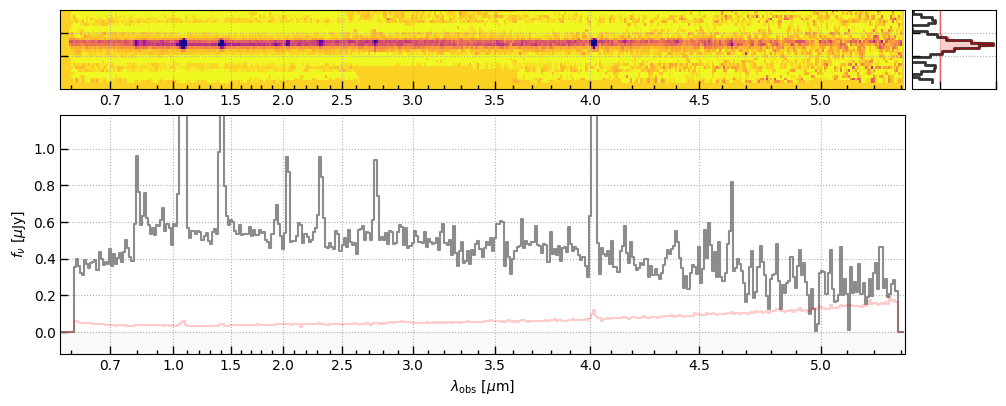

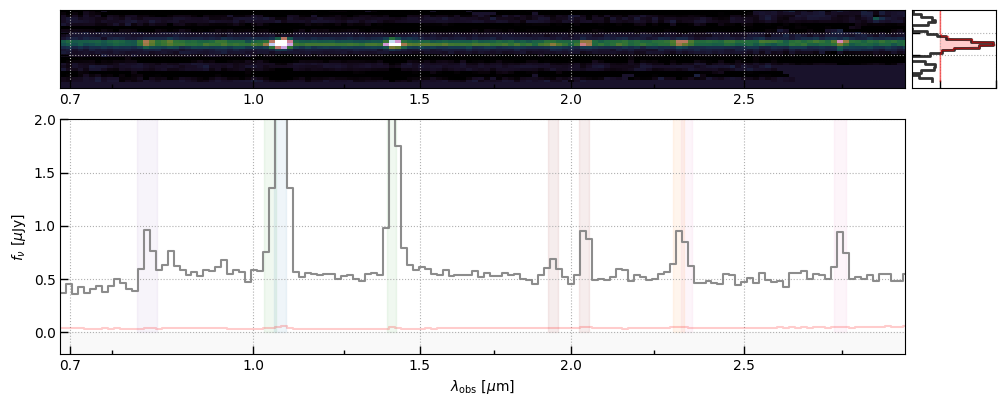

In [25]:
# Make figures showing 2D / 1D spectra
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=None)

# Other plot options
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=(0.69, 2.9), # zoom on wavelength range
                                        tick_steps=[0.5, 0.25], # major, minor
                                        ymax=2,   # y extent of plot and 2D scaling
                                        z=1.1417, # indicate strong lines for a given redshift
                                        cmap='cubehelix')


1.3608248551214457


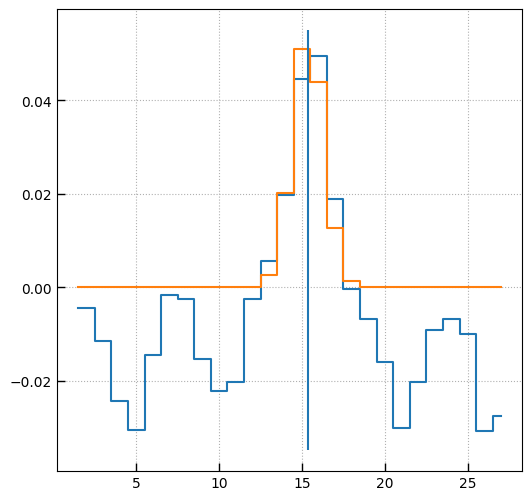

In [26]:
# Show the optimal extraction profile

sp = grizli.utils.GTable(hdul['SPEC1D'].data)
slx = slice(300, -1)

pden = np.nansum(hdul['WHT'].data[:,slx], axis=1)
snum = np.nansum((hdul['SCI'].data*hdul['WHT'].data)[:,slx], axis=1)
pnum = np.nansum((hdul['PROFILE'].data*hdul['WHT'].data*sp['flux'])[:,slx], axis=1)

y0 = hdul['PROFILE'].header['NAXIS2']/2. + hdul['SPEC1D'].header['PROFCEN']
print(hdul['SPEC1D'].header['PROFCEN'])
xx = np.arange(len(snum))
plt.step(xx, snum/pden, where='mid')
plt.step(xx, pnum/pden, where='mid')
plt.vlines(y0, *plt.ylim())
plt.grid()
